In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import scipy.io
import tensorflow as tf


from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from keras.losses import sparse_categorical_crossentropy

import matplotlib.pyplot as plt
import math
import numpy as np

In [5]:
mat = scipy.io.loadmat('USPS_all.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed May 09 15:12:18 2007',
 '__version__': '1.0',
 '__globals__': [],
 'fea': array([[-1.      , -1.      , -1.      , ..., -0.988672, -0.999475,
         -0.999994],
        [-0.999927, -0.993644, -0.900309, ..., -0.32939 , -0.584681,
         -0.868793],
        [-1.      , -1.      , -1.      , ..., -0.988116, -0.999864,
         -1.      ],
        ...,
        [-0.999985, -0.998547, -0.966704, ..., -1.      , -1.      ,
         -1.      ],
        [-0.999889, -0.996943, -0.962894, ..., -0.998277, -0.999924,
         -0.999998],
        [-1.      , -1.      , -1.      , ..., -0.999995, -1.      ,
         -1.      ]]),
 'gnd': array([[7],
        [6],
        [5],
        ...,
        [5],
        [1],
        [2]], dtype=uint8)}

(9298, 256)
(9298, 1)


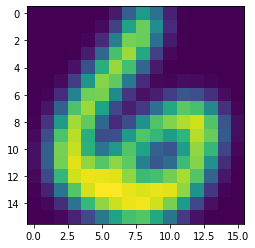

In [6]:
inputs = mat['fea']
targets = mat['gnd']
print(inputs.shape)
print(targets.shape)

reshapedInputs = []

for row in inputs:
    reshapedInputs.append(np.reshape(row,(16,16)))
    
reshapedInputs = np.array(reshapedInputs)
plt.imshow(reshapedInputs[0])

In [7]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [8]:
def create_model(layers, nodes=100, activation1="relu", activation2="relu", loss="sparse_categorical_crossentropy", optimizer="adam", bias='zeros'):    
    model = Sequential()
    for i in range(0, layers):
        model.add(Conv2D(32,(3,3), activation=activation1, input_shape=(16,16,1), bias_initializer=bias))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    
    model.add(Dense(nodes, activation=activation1, bias_initializer=bias))
    model.add(Dense(10, activation=activation2, bias_initializer=bias))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [9]:
#optimizing number of layer & number of nodes
bestLayers = []
for train, test in kfold.split(reshapedInputs, targets):
    print("fold:", fold_no)
    model = KerasClassifier(build_fn=create_model)
    
    layers = [1,2,3]
    batch_size = [32]
    epochs = [50]
    param_grid = dict(layers=layers, batch_size=batch_size, epochs=epochs)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=[(slice(None), slice(None))])
    grid_result = grid_search.fit(reshapedInputs[train], targets[train])
    
    bestLayers.append((grid_result.best_params_).get('layers'))
    print("Best accuracy:", grid_result.best_score_)
    print("Best params:", grid_result.best_params_)
    fold_no += 1

fold: 1
Best accuracy: 0.1667114794254303
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1}
fold: 2
Best accuracy: 0.16899704933166504
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1}
fold: 3
Best accuracy: 0.16711480915546417
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1}
fold: 4
Best accuracy: 0.16440381109714508
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1}
fold: 5
Best accuracy: 0.16789890825748444
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1}


In [10]:
import statistics
from statistics import mode

bestLayer = mode(bestLayers)

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [11]:
bestNodes = []
for train, test in kfold.split(reshapedInputs, targets):
    print("fold:", fold_no)
    model = KerasClassifier(build_fn=create_model)
    
    layers = [bestLayer]
    nodes = [90, 100, 110, 120]
    batch_size = [32]
    epochs = [50]
    param_grid = dict(layers=layers, nodes=nodes, batch_size=batch_size, epochs=epochs)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
    grid_result = grid_search.fit(reshapedInputs[train], targets[train])
    
    bestNodes.append((grid_result.best_params_).get('nodes'))
    print("Best accuracy:", grid_result.best_score_)
    print("Best params:", grid_result.best_params_)
    fold_no += 1

fold: 1
Best accuracy: 0.1685951203107834
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 2
Best accuracy: 0.1687271773815155
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 3
Best accuracy: 0.16711562871932983
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 4
Best accuracy: 0.16480790674686432
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 5
Best accuracy: 0.16601939201354982
Best params: {'batch_size': 32, 'epochs': 50, 'layers': 1, 'nodes': 90}


In [12]:
bestNode = mode(bestNodes)

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [13]:
bestBiasses = []
for train, test in kfold.split(reshapedInputs, targets):
    print("fold:", fold_no)
    model = KerasClassifier(build_fn=create_model)
    
    bias = ['zeros', 'ones']
    layers = [bestLayer]
    nodes = [bestNode]
    batch_size = [32]
    epochs = [50]
    param_grid = dict(bias=bias, layers=layers, nodes=nodes, batch_size=batch_size, epochs=epochs)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
    grid_result = grid_search.fit(reshapedInputs[train], targets[train])
    
    bestBiasses.append((grid_result.best_params_).get('bias'))
    print("Best accuracy:", grid_result.best_score_)
    print("Best params:", grid_result.best_params_)
    fold_no += 1

fold: 1
Best accuracy: 0.1637548714876175
Best params: {'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 2
Best accuracy: 0.16765235960483552
Best params: {'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 3
Best accuracy: 0.16590577065944673
Best params: {'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 4
Best accuracy: 0.16991624534130095
Best params: {'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 5
Best accuracy: 0.16789911985397338
Best params: {'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}


In [14]:
bestBias = mode(bestBiasses)

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [15]:
bestActivation1 = []
bestActivation2 = []
for train, test in kfold.split(reshapedInputs, targets):
    print("fold:", fold_no)
    model = KerasClassifier(build_fn=create_model)
    
    activation1 = ['relu','softmax']
    activation2 = ['relu','softmax']
    bias = [bestBias]
    layers = [bestLayer]
    nodes = [bestNode]
    batch_size = [32]
    epochs = [50]
    param_grid = dict(activation1=activation1,activation2=activation2, bias=bias, layers=layers, nodes=nodes, batch_size=batch_size, epochs=epochs)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid_search.fit(reshapedInputs[train], targets[train])
    
    bestActivation1.append((grid_result.best_params_).get('activation1'))
    bestActivation2.append((grid_result.best_params_).get('activation2'))
    print("Best accuracy:", grid_result.best_score_)
    print("Best params:", grid_result.best_params_)
    fold_no += 1

fold: 1
Best accuracy: 0.9800997614860535
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 2
Best accuracy: 0.9796974420547485
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 3
Best accuracy: 0.9780836343765259
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 4
Best accuracy: 0.9788916230201721
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}
fold: 5
Best accuracy: 0.9758007764816284
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90}


In [16]:
bActivation1 = mode(bestActivation1)
bActivation2 = mode(bestActivation2)

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [17]:
bestOptimizers = []
for train, test in kfold.split(reshapedInputs, targets):
    print("fold:", fold_no)
    model = KerasClassifier(build_fn=create_model)
    
    optimizer = ['adam', 'sgd', 'Adamax']
    activation1 = [bActivation1]
    activation2 = [bActivation2]
    bias = [bestBias]
    layers = [bestLayer]
    nodes = [bestNode]
    batch_size = [32]
    epochs = [50]
    param_grid = dict(optimizer=optimizer, activation1=activation1,activation2=activation2, bias=bias, layers=layers, nodes=nodes, batch_size=batch_size, epochs=epochs)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2)
    grid_result = grid_search.fit(reshapedInputs[train], targets[train])
    
    bestOptimizers.append((grid_result.best_params_).get('optimizer'))
    print("Best accuracy:", grid_result.best_score_)
    print("Best params:", grid_result.best_params_)
    fold_no += 1

fold: 1
Best accuracy: 0.9759315609931946
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90, 'optimizer': 'adam'}
fold: 2
Best accuracy: 0.976066780090332
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90, 'optimizer': 'Adamax'}
fold: 3
Best accuracy: 0.9768725991249084
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90, 'optimizer': 'Adamax'}
fold: 4
Best accuracy: 0.9784886717796326
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90, 'optimizer': 'adam'}
fold: 5
Best accuracy: 0.9805056095123291
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90, 'optimizer': 

In [18]:
bestOptimizer = mode(bestOptimizers)

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [19]:
bestEpochs = []
bestBatches = []
for train, test in kfold.split(reshapedInputs, targets):
    print("fold:", fold_no)
    model = KerasClassifier(build_fn=create_model)
    
    optimizer = [bestOptimizer]
    activation1 = [bActivation1]
    activation2 = [bActivation2]
    bias = [bestBias]
    layers = [bestLayer]
    nodes = [bestNode]
    batch_size = [16,32,64,128]
    epochs = [40,50,60,70,80]
    param_grid = dict(optimizer=optimizer, activation1=activation1,activation2=activation2, bias=bias, layers=layers, nodes=nodes, batch_size=batch_size, epochs=epochs)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
    grid_result = grid_search.fit(reshapedInputs[train], targets[train])
    
    bestBatches.append((grid_result.best_params_).get('batch_size'))
    bestEpochs.append((grid_result.best_params_).get('epochs'))
    print("Best accuracy:", grid_result.best_score_)
    print("Best params:", grid_result.best_params_)
    fold_no += 1

fold: 1
Best accuracy: 0.981041157245636
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 50, 'layers': 1, 'nodes': 90, 'optimizer': 'adam'}
fold: 2
Best accuracy: 0.9806375861167907
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 70, 'layers': 1, 'nodes': 90, 'optimizer': 'adam'}
fold: 3
Best accuracy: 0.9814437627792358
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 64, 'bias': 'zeros', 'epochs': 80, 'layers': 1, 'nodes': 90, 'optimizer': 'adam'}
fold: 4
Best accuracy: 0.9806397438049317
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 60, 'layers': 1, 'nodes': 90, 'optimizer': 'adam'}
fold: 5
Best accuracy: 0.9796979784965515
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 32, 'bias': 'zeros', 'epochs': 70, 'layers': 1, 'nodes': 90, 'optimizer': 'ada

In [20]:
bestEpoch = mode(bestEpochs)
bestBatch = mode(bestBatches)

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [21]:
def create_model1(layers, nodes=100, activation1="relu", activation2="relu", loss="sparse_categorical_crossentropy", learn_rate=0.01, bias='zeros'):    
    model = Sequential()
    for i in range(0, layers):
        model.add(Conv2D(32,(3,3), activation=activation1, input_shape=(16,16,1), bias_initializer=bias))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    
    model.add(Dense(nodes, activation=activation1, bias_initializer=bias))
    model.add(Dense(10, activation=activation2, bias_initializer=bias))
    
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [23]:
bestLearnRates = []
for train, test in kfold.split(reshapedInputs, targets):
    print("fold:", fold_no)
    model = KerasClassifier(build_fn=create_model1)
    
    learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
    activation1 = [bActivation1]
    activation2 = [bActivation2]
    bias = [bestBias]
    layers = [bestLayer]
    nodes = [bestNode]
    batch_size = [bestBatch]
    epochs = [bestEpoch]
    param_grid = dict(learn_rate=learn_rate, activation1=activation1,activation2=activation2, bias=bias, layers=layers, nodes=nodes, batch_size=batch_size, epochs=epochs)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=3)
    grid_result = grid_search.fit(reshapedInputs[train], targets[train])
    
    bestLearnRates.append((grid_result.best_params_).get('learn_rate'))

    print("Best accuracy:", grid_result.best_score_)
    print("Best params:", grid_result.best_params_)
    fold_no += 1

fold: 6
Best accuracy: 0.9795623064041138
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 70, 'layers': 1, 'learn_rate': 0.001, 'nodes': 90}
fold: 7
Best accuracy: 0.9757992267608643
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 70, 'layers': 1, 'learn_rate': 0.001, 'nodes': 90}
fold: 8
Best accuracy: 0.9792927622795105
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 70, 'layers': 1, 'learn_rate': 0.001, 'nodes': 90}
fold: 9
Best accuracy: 0.9790266633033753
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 70, 'layers': 1, 'learn_rate': 0.001, 'nodes': 90}
fold: 10
Best accuracy: 0.9807740688323975
Best params: {'activation1': 'relu', 'activation2': 'softmax', 'batch_size': 16, 'bias': 'zeros', 'epochs': 70, 'layers': 1, 'learn_rate': 0.001, 'nodes'

In [24]:
bestLearnRate = mode(bestLearnRates)

In [33]:
print("Best number of layers:", bestLayer)
print("Best number of nodes:", bestNode)
print("Best bias initializer:", bestBias)
print("Best activation function 1:", bActivation1)
print("Best activation function 2:", bActivation2)
print("Best optimizer:", bestOptimizer)
print("Best number of epochs:", bestEpoch)
print("Best batch size:", bestBatch)
print("Best learning rate:", bestLearnRate)

Best number of layers: 1
Best number of nodes: 90
Best bias initializer: zeros
Best activation function 1: relu
Best activation function 2: softmax
Best optimizer: adam
Best number of epochs: 70
Best batch size: 16
Best learning rate: 0.001


In [73]:
def create_model2(loss="sparse_categorical_crossentropy"):    
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation='relu', input_shape=(16,16,1), bias_initializer='zeros'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    
    model.add(Dense(90, activation='relu', bias_initializer='zeros'))
    model.add(Dense(10, activation='softmax', bias_initializer='zeros'))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [74]:
kfold = KFold(n_splits=2, shuffle=True)
fold_no = 1

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc, precision_score, recall_score, f1_score

for train, test in kfold.split(reshapedInputs, targets):
    model = KerasClassifier(build_fn=create_model2)
    hist = model.fit(reshapedInputs[train],targets[train], epochs=70, batch_size=16)
    
    pred1 = model.predict(reshapedInputs[test])
    pred2 = model.predict_proba(reshapedInputs[test])
    
    precision = precision_score(targets[test],pred1, average='weighted')
    recall = recall_score(targets[test],pred1, average='weighted')
    f1 = f1_score(targets[test],pred1, average='weighted')
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1)
    print("\n")


fold: 1
Precision:  0.9800324728375929
Recall:  0.9799956979995698
F1 score:  0.9799562430882062


fold: 2
Precision:  0.9781058117013591
Recall:  0.9780597978059797
F1 score:  0.9780447421028026


